- 데이터 다운로드

In [2]:
import pandas_datareader as web
import pandas as pd

tickers = ['SPY', # 미국 주식
            'IEV', # 유럽 주식 
            'EWJ', # 일본 주식
            'EEM', # 이머징 주식
            'TLT', # 미국 장기채
            'IEF', # 미국 중기채
            'IYR', # 미국 리츠
            'RWX', # 글로벌 리츠
            'GLD', # 금
            'DBC'  # 상품
            ]

all_data = {}
for ticker in tickers:
    all_data[ticker] = web.DataReader(ticker, 'yahoo')

In [241]:
prices = pd.DataFrame({tic: data['Adj Close'] for tic, data in all_data.items()})
prices.to_csv('data/asset_data.csv')

In [9]:
import pandas as pd

prices = pd.read_csv('data/asset_data.csv', index_col = 0)

In [11]:
rets = prices.pct_change(1).dropna()

In [11]:
rets

,SPY,IEV,EWJ,EEM,TLT,IEF,IYR,RWX,GLD,DBC
Date,,,,,,,,,,
2016-02-09,0.000054,-0.008882,-0.019213,-0.013851,0.001065,0.000181,-0.016174,-0.004065,-0.002196,-0.025662
2016-02-10,-0.000863,0.004200,-0.017724,0.004111,0.008812,0.002984,0.005231,0.000272,0.007748,0.001646
2016-02-11,-0.013008,-0.014222,-0.019943,-0.016718,0.007003,0.004598,-0.014719,-0.008433,0.040189,0.012325
2016-02-12,0.020617,0.019519,0.008721,0.017349,-0.016602,-0.007628,0.012977,0.015089,-0.005879,0.014610
2016-02-16,0.016878,0.016093,0.036503,0.022169,-0.010570,-0.002984,0.019217,0.020270,-0.030331,-0.011200
...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.016646,0.013551,0.010449,0.027012,0.001159,0.001248,0.024156,0.000297,0.009385,0.019092
2021-02-02,0.014140,0.009400,0.007978,0.012968,-0.006447,-0.002527,0.005381,0.004160,-0.012168,0.007752
2021-02-03,0.000786,0.001863,0.005862,0.005049,-0.008873,-0.002449,-0.002733,0.000000,-0.001511,0.007051


<AxesSubplot:>

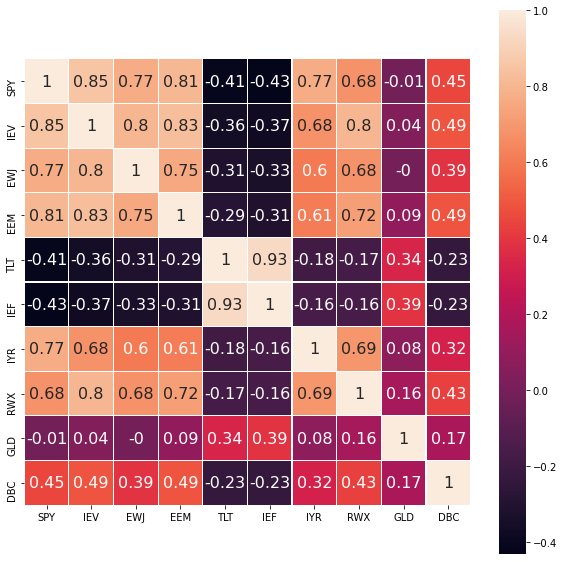

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(rets.corr().round(2), linewidths = 0.1, vmax = 1.0, square = True, linecolor = "white", annot = True, annot_kws = {"size" : 16})

In [12]:
covmat = pd.DataFrame.cov(rets)

## 11.1 최소분산 포트폴리오

### 11.1.1 solvers.qp 함수를 이용한 최적화

- CVXOPT 패키지 이용
- CVXOPT Link:  https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf

목적함수
$$ \min \frac{1}{2} x^TPx + q^Tx $$  

제약조건
$$Gx  ≤ h$$
$$Ax = b$$

**예시**

- 목적함수
$$\min_{x,y} \frac{1}{2}x^2 + 3x + 4y $$
- 제약조건
$$x,y \ge 0$$ 
$$ x + 3y \ge 15 $$
$$ 2x + 5y \le 100 $$
$$ 3x + 4y \le 80 $$

**행렬로 전환하면 다음과 같음**

- 목적함수
$$ \min_{x,y} \frac{1}{2} \begin{bmatrix} x \\ y \end{bmatrix}^T \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} +
   \begin{bmatrix} 3 \\ 4 \end{bmatrix}^T + \begin{bmatrix} x \\ y \end{bmatrix} $$
   
- 제약함수
$$ \begin{bmatrix} -1 & 0 \\ 0 & -1 \\ -1 & -3 \\ 2 & 5 \\ 3 & 4 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} \le \begin{bmatrix} 0 \\ 0 \\ -15 \\ 100 \\ 80 \end{bmatrix}$$

$x = \begin{bmatrix} x \\ y \end{bmatrix},\ P = \begin{bmatrix} 1 & 0 \\ 0 & 0 \end{bmatrix},\ q =  \begin{bmatrix} 3 \\ 4 \end{bmatrix}$

$G = \begin{bmatrix} -1 & 0 \\ 0 & -1 \\ -1 & -3 \\ 2 & 5 \\ 3 & 4 \end{bmatrix} \ h = \begin{bmatrix} 0 \\ 0 \\ -15 \\ 100 \\ 80 \end{bmatrix}$

- 위 형태를 만들어서 함수 내에 넣어주면 최적값 구해줌

In [7]:
from cvxopt import matrix
from cvxopt import solvers
import numpy as np

P = matrix(np.diag([1,0]), tc= 'd')
q = matrix(np.array([3,4]), tc= 'd')
G = matrix(np.array([[-1,0],[0,-1],[-1,-3],[2,5],[3,4]]), tc= 'd')
h = matrix(np.array([0,0,-15,100,80]), tc= 'd')

sol = solvers.qp(P,q,G,h)

     pcost       dcost       gap    pres   dres
 0:  1.0780e+02 -7.6366e+02  9e+02  0e+00  4e+01
 1:  9.3245e+01  9.7637e+00  8e+01  6e-17  3e+00
 2:  6.7311e+01  3.2553e+01  3e+01  2e-16  1e+00
 3:  2.6071e+01  1.5068e+01  1e+01  2e-16  7e-01
 4:  3.7092e+01  2.3152e+01  1e+01  1e-16  4e-01
 5:  2.5352e+01  1.8652e+01  7e+00  6e-17  3e-16
 6:  2.0062e+01  1.9974e+01  9e-02  9e-17  2e-16
 7:  2.0001e+01  2.0000e+01  9e-04  2e-16  1e-16
 8:  2.0000e+01  2.0000e+01  9e-06  1e-16  3e-16
Optimal solution found.


In [8]:
np.array(sol['x']).round(2)

array([[0.],
       [5.]])

### 11.1.2 최소분산 포트폴리오 계산하기

- 목적함수

solvers.qp() 함수에서는 $ \min \frac{1}{2} x^TPx + q^Tx $ 이며, 최소분산 포트폴리오에서는 $ \min \frac{1}{2}w'\Omega w $

따라서 각각 $x → w$, $P → \Omega$, $q → 0$ 에 대응된다.


- 제약조건: 부등식

함수에서는 $Gx  ≤ h$, 최소분산 포트폴리오 에서는 $w_i \ge 0$

최소분산 포트폴리오의 부등식 제약조건 $w_i \ge 0$을 행렬로 표현하면 다음과 같음

$$ \begin{bmatrix} 1 &  \dots & 0 \\ \vdots &  \ddots & \vdots \\ 0 &  \dots & 1 \end{bmatrix}
\begin{bmatrix} w_1 \\  \vdots \\ w_n \end{bmatrix}  \ge \begin{bmatrix} 0 \\  \vdots \\ 0 \end{bmatrix}$$

solvers.qp() 함수에서는 우변에 더 큰 형태이므로, 이를 맞춰주기 위해 양변에 음수를 곱해주면 다음과 같음

$$\begin{bmatrix}-1 & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & -1 \end{bmatrix} \begin{bmatrix} w_1 \\  \vdots \\ w_n \end{bmatrix} \le \begin{bmatrix} 0 \\  \vdots \\ 0 \end{bmatrix}$$

따라서 $G → \begin{bmatrix}-1 & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & -1 \end{bmatrix} $, $h →\begin{bmatrix} 0 \\  \vdots \\ 0 \end{bmatrix}$에 대응된다.

- 제약조건: 등식

solvers.qp() 함수에서는 $Ax = b$, 최소분산 포트폴리오 에서는 $\sum_{i=1}^{n}w_i = 1$

최소분산 포트폴리오의 부등식 제약조건 $\sum_{i=1}^{n}w_i = 1$을 행렬로 표현하면 다음과 같음

$$\begin{bmatrix}1 & \dots & 1 \end{bmatrix}\begin{bmatrix} w_1 \\  \vdots \\ w_n \end{bmatrix} = 1 $$ 

따라서 $A → \begin{bmatrix}1 & \dots & 1 \end{bmatrix}$, $b → 1$에 대응된다.


In [21]:
P = matrix(np.array(covmat), tc = 'd') # 분산-공분산 행렬
q = matrix(np.zeros(10), tc = 'd') #0  행렬

G = matrix(np.diag(np.repeat(-1, 10)) , tc = 'd') # 부등식 제약조건의 좌변
h = matrix(np.repeat(0, 10) , tc = 'd') # 부등식 제약조건의 우변
A = matrix(np.repeat(1, 10), tc = 'd').T # 등식 제약조건의 좌변
b = matrix(1, tc = 'd') # 등식 제약조건의 우변

In [22]:
sol = solvers.qp(P,q,G,h, A, b)

res = np.array(sol['x']).round(3)
res

     pcost       dcost       gap    pres   dres
 0:  2.3861e-05 -1.0000e+00  1e+00  2e-16  3e+00
 1:  2.3858e-05 -1.0031e-02  1e-02  7e-17  3e-02
 2:  2.3656e-05 -1.3077e-04  2e-04  8e-17  5e-04
 3:  1.5596e-05 -1.5581e-05  3e-05  6e-17  9e-05
 4:  8.7465e-06 -1.3361e-05  2e-05  2e-16  5e-05
 5:  4.2114e-06  1.3927e-06  3e-06  1e-16  2e-20
 6:  3.5495e-06  3.1315e-06  4e-07  3e-16  8e-21
 7:  3.3154e-06  3.2408e-06  7e-08  1e-16  5e-21
Optimal solution found.


array([[0.087],
       [0.009],
       [0.034],
       [0.003],
       [0.001],
       [0.805],
       [0.001],
       [0.003],
       [0.001],
       [0.057]])

<AxesSubplot:>

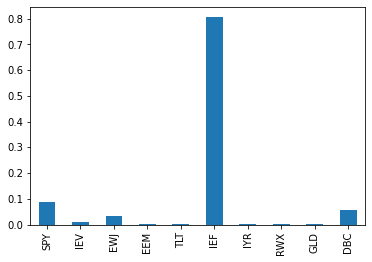

In [23]:
res_df = pd.DataFrame(res)
res_df.index = rets.columns

res_df.plot(kind = 'bar', legend = False)

## 11.1.3 최소 및 최대 투자비중 제약조건

부등식 제약조건 $0.05 \le w_i \le 0.2$로 바꿈

이를 $Gx  ≤ h$의 형태로 나타내면 다음과 같음

$$\begin{bmatrix}-1 & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & -1 \\ 1 & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & 1\end{bmatrix} \begin{bmatrix} w_1 \\  \vdots \\ w_n \end{bmatrix} \le \begin{bmatrix} -0.05 \\  \vdots \\ -0.05 \\ 0.2 \\ \vdots \\ 0.2 \end{bmatrix}$$

In [24]:
P = matrix(np.array(covmat), tc = 'd') # 분산-공분산 행렬
q = matrix(np.zeros(10), tc = 'd') #0  행렬

G = matrix(np.concatenate( (np.diag(np.repeat(-1, 10)), np.diag(np.repeat(1, 10)))) , tc = 'd') # 부등식 제약조건의 좌변
h = matrix(np.concatenate( (np.repeat(-0.05, 10), np.repeat(0.2, 10))) , tc = 'd') # 부등식 제약조건의 우변
A = matrix(np.repeat(1, 10), tc = 'd').T # 등식 제약조건의 좌변
b = matrix(1, tc = 'd') # 등식 제약조건의 우변

In [25]:
sol = solvers.qp(P,q,G,h, A, b)

res = np.array(sol['x']).round(3)
res

     pcost       dcost       gap    pres   dres
 0:  2.3866e-05 -1.5250e+00  2e+00  1e-16  3e-16
 1:  2.3865e-05 -1.5280e-02  2e-02  2e-16  5e-16
 2:  2.3799e-05 -1.8247e-04  2e-04  1e-16  5e-18
 3:  2.0110e-05 -1.2692e-05  3e-05  5e-17  8e-19
 4:  1.2717e-05  8.2178e-06  4e-06  9e-17  3e-20
 5:  1.1116e-05  1.0598e-05  5e-07  8e-17  2e-20
 6:  1.0828e-05  1.0799e-05  3e-08  2e-16  1e-20
Optimal solution found.


array([[0.051],
       [0.05 ],
       [0.054],
       [0.05 ],
       [0.2  ],
       [0.2  ],
       [0.05 ],
       [0.05 ],
       [0.178],
       [0.116]])

<AxesSubplot:>

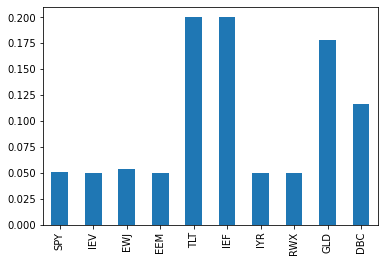

In [26]:
res_df = pd.DataFrame(res)
res_df.index = rets.columns

res_df.plot(kind = 'bar', legend = False)

### 11.1.4 각 자산별 제약조건의 추가

|제약|1|2|3|4|5|6|7|8|9|10|
|---|---|---|---|---|---|---|---|---|---|---
|최소|0.10|0.10|0.05|0.05|0.10|0.10|0.05|0.05|0.03|0.03|
|최대|0.25|0.25|0.20|0.20|0.20|0.20|0.10|0.10|0.08|0.08|

이를 $Gx  ≤ h$의 형태로 나타내면 다음과 같음

$$ \begin{bmatrix} -1 & \dots & 0 \\ \vdots & \ddots & \vdots \\
0 & \dots & -1 \\ 1 & \dots & 0 \\ \vdots &  \ddots & \vdots \\
0 & \dots & 1 \\ \\ \end{bmatrix}
\begin{bmatrix} w_1 \\ w_2 \\ \vdots \\ w_{10} \end{bmatrix} 
= \begin{bmatrix} -w_1 \\ -w_2 \\ -w_3 \\ -w_4 \\ -w_5 \\ -w_6 \\ -w_7 \\ -w_8 \\ -w_9 \\ -w_{10} \\ w_1 \\ w_2 \\ w_3 \\ w_4 \\ w_5 \\ w_6 \\ w_7\\ w_8\\ w_9\\ w_{10} \end{bmatrix} \le \begin{bmatrix} -0.10 \\ -0.10 \\ -0.05 \\ -0.05 \\ -0.10 \\ -0.10 \\ -0.05 \\ -0.05 \\ -0.03 \\ -0.03 \\ 0.25 \\ 0.25 \\ 0.20 \\ 0.20 \\ 0.20 \\ 0.20 \\ 0.10 \\ 0.10 \\ 0.08 \\ 0.08
\end{bmatrix} $$

In [31]:
boundary = np.array([-0.10, -0.10, -0.05, -0.05, -0.10, -0.10, -0.05, -0.05, -0.03, -0.03,
                    0.25, 0.25, 0.20, 0.20, 0.20, 0.20, 0.10, 0.10, 0.08, 0.08])

P = matrix(np.array(covmat), tc = 'd') # 분산-공분산 행렬
q = matrix(np.zeros(10), tc = 'd') #0  행렬

G = matrix(np.concatenate( (np.diag(np.repeat(-1, 10)), np.diag(np.repeat(1, 10)))) , tc = 'd') # 부등식 제약조건의 좌변
h = matrix(boundary, tc = 'd') # 부등식 제약조건의 우변
A = matrix(np.repeat(1, 10), tc = 'd').T # 등식 제약조건의 좌변
b = matrix(1, tc = 'd') # 등식 제약조건의 우변

In [32]:
sol = solvers.qp(P,q,G,h, A, b)

res = np.array(sol['x']).round(3)
res

     pcost       dcost       gap    pres   dres
 0:  2.4674e-05 -1.0259e+00  1e+00  0e+00  4e-16
 1:  2.4674e-05 -1.0275e-02  1e-02  8e-17  5e-16
 2:  2.4625e-05 -1.1869e-04  1e-04  2e-16  9e-18
 3:  2.1682e-05 -2.8431e-06  2e-05  2e-16  1e-18
 4:  1.4840e-05  7.8503e-06  7e-06  7e-17  5e-20
 5:  1.3467e-05  1.2059e-05  1e-06  8e-17  2e-20
 6:  1.3080e-05  1.2808e-05  3e-07  1e-16  2e-20
 7:  1.2958e-05  1.2954e-05  4e-09  8e-17  2e-20
Optimal solution found.


array([[0.1 ],
       [0.1 ],
       [0.09],
       [0.05],
       [0.2 ],
       [0.2 ],
       [0.05],
       [0.05],
       [0.08],
       [0.08]])

<AxesSubplot:>

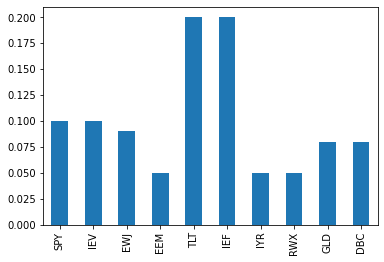

In [33]:
res_df = pd.DataFrame(res)
res_df.index = rets.columns

res_df.plot(kind = 'bar', legend = False)

## 11.2 위험 균형 포트폴리오

### 11.2.1 주식 60%와 채권 40% 포트폴리오의 위험기여도

In [28]:
import pandas as pd
import numpy as np

def RC(weight, covmat) :
    weight = np.array(weight)
    variance = weight.T @ covmat @ weight
    sigma = variance ** 0.5
    mrc = 1/sigma * (weight @ covmat)
    rc = weight * mrc
    rc = rc / rc.sum()
    return(rc)

- $w$: weight
- $\Omega $: variance
- $w'\Omega w$: sigma

In [146]:
ret_stock_bond  = rets.loc[:, ['SPY', 'TLT']]
cov_stock_bond = pd.DataFrame.cov(ret_stock_bond)
RC_stock_bond  = RC([0.6, 0.4], cov_stock_bond).round(4)

In [147]:
RC_stock_bond

SPY    0.9518
TLT    0.0482
dtype: float64

### 11.2.2 minimize() 함수를 이용한 최적화

- scipy.optimize의 minimize() 함수 사용
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html

- 이 중 slsqp(Sequential Least Squares Programming) 방법 사용

목적함수
$$ \min f(x) $$  

제약조건
$$b(x) \ge 0$$
$$c(x) = 0$$

함수 형태는 다음과 같음

- minimize(fun, x0, method=, bounds, constraints, options)

- fun: 목적함수
- x0: 초기값
- bounds: 변수 범위
- constraints: 제약조건
- options: 기타 옵션

**예시**

- 목적함수
$$\min x_1 x_4(x_1 + x_2 + x_3) + x3$$

- 제약조건
$$x_1 x_2 x_3 x_4 \ge 25$$
$$x_1^2 + x_2^2 + x_3^2 + x_4^2 = 40$$
$$1 \le x_1, x_2, x_3, x_4 \le 5$$


In [38]:
# 목적식
def obj_function(x) :
    
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    x4 = x[3]
    
    return x1*x4*(x1+x2+x3)+x3

# 제약조건 1
def cons_1(x) :
    return x[0]*x[1]*x[2]*x[3] - 25

# 제약조건 2
def cons_2(x) :
    return x[0]**2 + x[1]**2 + x[2]**2 + x[3]**2 - 40


- 첫번째 제약조건은 $x_1 x_2 x_3 x_4 \ge 25$
- 함수에서는 $b(x) \ge 0$ 형태로 입력해주어야 하므로 25를 좌변으로 넘김
- 두번째 제약조건 역시 $c(x) = 0$ 형태를 만들기 위해 40을 좌변으로 넘김
- 세번째 변수 범위 제약조건은 함수 내에 직접 입력

In [39]:
x0 = [1, 5, 5, 1]
bnds = ((1, 5), ) * 4

constraints = ({'type': 'ineq', 'fun': cons_1},
               {'type': 'eq', 'fun': cons_2})
options = {'ftol': 1e-20, 'maxiter': 800}

result = minimize(fun = obj_function,
                  x0 = x0,
                  method = 'SLSQP',
                  bounds = bnds,
                  constraints = constraints,                      
                  options = options)

In [40]:
result

     fun: 17.014017289156026
     jac: array([14.5722754 ,  1.37940812,  2.37940812,  9.56414962])
 message: 'Positive directional derivative for linesearch'
    nfev: 104
     nit: 16
    njev: 12
  status: 8
 success: False
       x: array([1.        , 4.74299961, 3.82115002, 1.37940829])

- fun: 목적함수의 결과물
- x: 최적값을 만족하는 해

In [41]:
result['x']

array([1.        , 4.74299961, 3.82115002, 1.37940829])

### 11.2.3 위험균형 포트폴리오 계산하기

목적조건: $min \sum_{i=1}^{n}(Target RC_{i} - RC_{i})^2$

제약조건: $\sum_{i=1}^{n}w_i = 1, w_i \ge 0 $

In [43]:
# 목적식
def RiskParity_objective(weight) :
    
    weight = np.array(weight)
    variance = weight.T @ covmat @ weight
    sigma = variance ** 0.5
    mrc = 1/sigma * (weight @ covmat)
    rc = weight * mrc
    rc = rc / rc.sum()
    
    target = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
    risk_diffs = rc - target
    sum_risk_diffs_squared = np.sum(np.square(risk_diffs.values))
    return (sum_risk_diffs_squared)

# 제약조건 1: 합계가 1
def weight_sum_constraint(x) :
    return(x.sum() - 1.0 )

# 제약조건 2: 비중이 0보다 클 것
def weight_longonly(x) :
    return(x)

In [46]:
def RiskParity(covmat) :
    
    x0 = np.repeat(0.1, 10) 
    bnds = ((0, 1), ) * 10
    
    constraints = ({'type': 'eq', 'fun': weight_sum_constraint},
                   {'type': 'ineq', 'fun': weight_longonly})
    options = {'ftol': 1e-20, 'maxiter': 800}
    
    result = minimize(fun = RiskParity_objective,
                      x0 = x0,
                      method = 'SLSQP',
                      bounds = bnds,
                      constraints = constraints,                      
                      options = options)
    return(result['x'])

In [47]:
from scipy.optimize import minimize
import numpy as np

res = RiskParity(covmat)

In [48]:
res

array([0.05824497, 0.05037431, 0.06472055, 0.04440103, 0.14331185,
       0.36599374, 0.04607843, 0.05267282, 0.09258011, 0.0816222 ])

<AxesSubplot:>

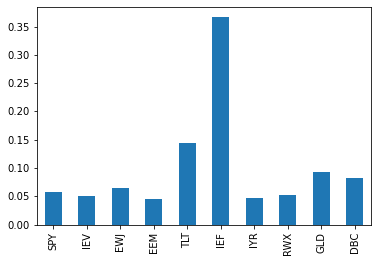

In [49]:
res_df = pd.DataFrame(res).set_index(rets.columns)
res_df.plot(kind = 'bar', legend = False)

In [29]:
RC(res.x, covmat)

SPY    0.1
IEV    0.1
EWJ    0.1
EEM    0.1
TLT    0.1
IEF    0.1
IYR    0.1
RWX    0.1
GLD    0.1
DBC    0.1
dtype: float64

### 11.2.4 위험예산 포트폴리오

In [50]:
def RiskParity_objective(weight) :
    
    weight = np.array(weight)
    variance = weight.T @ covmat @ weight
    sigma = variance ** 0.5
    mrc = 1/sigma * (weight @ covmat)
    rc = weight * mrc
    rc = rc / rc.sum()
    
    target = np.array([0.15, 0.15, 0.15, 0.15, 0.10, 0.10, 0.05, 0.05, 0.05, 0.05])
    risk_diffs = rc - target
    sum_risk_diffs_squared = np.sum(np.square(risk_diffs.values))
    return (sum_risk_diffs_squared)

# 제약조건 1: 합계가 1
def weight_sum_constraint(x) :
    return(x.sum() - 1.0 )

# 제약조건 2: 비중이 0보다 클 것
def weight_longonly(x) :
    return(x)

def RiskParity(covmat) :
    
    x0 = np.repeat(0.1, 10) 
    # target = np.array(target)
    constraints = ({'type': 'eq', 'fun': weight_sum_constraint},
                   {'type': 'ineq', 'fun': weight_longonly})
    options = {'ftol': 1e-20, 'maxiter': 800}
    
    result = minimize(fun = RiskParity_objective,
                      x0 = x0,
                      method = 'SLSQP',
                      constraints = constraints,                      
                      options = options)
    return(result['x'])

res_rc = RiskParity(covmat)

In [52]:
pd.DataFrame(res_rc).set_index(rets.columns)

,0
SPY,0.080432
IEV,0.070358
EWJ,0.087400
EEM,0.061755
TLT,0.151115
IEF,0.398800
IYR,0.022985
RWX,0.026236
GLD,0.055406
DBC,0.045512


In [53]:
RC(res_rc, covmat)

SPY    0.15
IEV    0.15
EWJ    0.15
EEM    0.15
TLT    0.10
IEF    0.10
IYR    0.05
RWX    0.05
GLD    0.05
DBC    0.05
dtype: float64